# Imports

In [90]:
# Import necessary libraries
from urllib.request import urlretrieve
import zipfile
import os
import shutil
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# Manual seeding for reproducibility
np.random.seed(42)       # Numpy module.
torch.manual_seed(42)    # PyTorch module.
if torch.cuda.is_available():  # If using GPU, set its seed as well.
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Check if CUDA is available for PyTorch, and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading and preprocessing the dataset

In [8]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    '../data/raw/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    '../data/raw/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'raw/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = (users["user_id"] - 1).astype(str)
movies["movie_id"] = (movies["movie_id"] - 1).astype(str)
movies["year"] = movies["release_date"].str.split('-').str[-1]
ratings["movie_id"] = (ratings["movie_id"] - 1).astype(str)
ratings["user_id"] = (ratings["user_id"] - 1).astype(str)
ratings["rating"] = ratings["rating"].astype(float)


# Encoding the data

# Label Encoding for Categorical Data in 'users'
label_encoder = LabelEncoder()

# Encoding 'sex'
users['sex'] = label_encoder.fit_transform(users['sex'])

# Encoding 'occupation'
users['occupation'] = label_encoder.fit_transform(users['occupation'])

# Encoding 'zip_code'
users['zip_code'] = label_encoder.fit_transform(users['zip_code'])

# Normalize the age:
users.age = (users.age - users.age.min()) / (users.age.max() - users.age.min())

# 'movies' DataFrame: genres are already in a binary format
# No further categorical encoding is needed for 'movies'

# 'ratings' DataFrame does not contain categorical data that needs encoding

# Display the first few rows of the modified 'users' DataFrame
users.head()

,user_id,age,sex,occupation,zip_code
0,0,0.257576,1,19,622
1,1,0.696970,0,13,689
2,2,0.242424,1,20,270
3,3,0.257576,1,19,331
4,4,0.393939,0,13,133


In [19]:
# Loading the first k-fold to build and initially test the model with
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
train_ratings = pd.read_csv(
    '../data/raw/u1.base', sep='\t', names=ratings_cols, encoding='latin-1')
train_ratings["user_id"] = (train_ratings["user_id"] - 1).astype(int)
train_ratings["movie_id"] = (train_ratings["movie_id"] - 1).astype(int)
train_ratings = train_ratings[['user_id', 'movie_id', 'rating']]

test_ratings = pd.read_csv(
    '../data/raw/u1.test', sep='\t', names=ratings_cols, encoding='latin-1')
test_ratings["user_id"] = (test_ratings["user_id"] - 1).astype(int)
test_ratings["movie_id"] = (test_ratings["movie_id"] - 1).astype(int)
test_ratings = test_ratings[['user_id', 'movie_id', 'rating']]
test_ratings

,user_id,movie_id,rating
0,0,5,5
1,0,9,3
2,0,11,5
3,0,13,5
4,0,16,3
...,...,...,...
19995,457,647,4
19996,457,1100,4
19997,458,933,3
19998,459,9,3


# Matrix factorization approach

## Building the dataset class

In [21]:
class MovieDataset(Dataset):
    """
    A custom dataset class for movie ratings data.

    Attributes:
    ratings: A numpy array of ratings.
    users_id: A numpy array of user IDs corresponding to each rating.
    movies_id: A numpy array of movie IDs corresponding to each rating.
    """

    def __init__(self, ratings_df):
        """
        Initializes the MovieDataset with data from a pandas DataFrame.

        Args:
        ratings_df (pd.DataFrame): A DataFrame containing movie ratings data with columns 'user_id', 'movie_id', and 'rating'.
        """
        super().__init__()
        self.ratings = ratings_df.rating.values
        self.users_id = ratings_df.user_id.values
        self.movies_id = ratings_df.movie_id.values

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.ratings)

    def __getitem__(self, idx):
        """
        Retrieves a single sample from the dataset.

        Args:
        idx (int): The index of the sample to retrieve.

        Returns:
        tuple: A tuple containing the user ID, movie ID, and rating for the sample.
        """
        return self.users_id[idx], self.movies_id[idx], self.ratings[idx]


In [25]:
# Define the batch size for loading the data
batch_size = 8192

# Create instances of the MovieDataset class for training and testing datasets
train_dataset = MovieDataset(train_ratings)
test_dataset = MovieDataset(test_ratings)

# DataLoader for the training dataset
# It loads the data in batches of size 'batch_size', shuffles the data for each epoch, and uses 0 worker processes
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# DataLoader for the testing dataset
# Similar to 'train_loader', but for the testing data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

## Building the matrix factorization model

Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and movie embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of movies,
- $A_{ij}$ is the rating of the $j$ th movies by the $i$ th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing movie $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.

Using this simple model, we can predict the ratings of the user for unseen movies and recommend them to the user

In [ ]:
class MatrixFactorization(nn.Module):
    """
    A PyTorch model for collaborative filtering using matrix factorization.

    Attributes:
    U (torch.nn.Embedding): User embedding matrix.
    V (torch.nn.Embedding): Item (movie) embedding matrix.
    """

    def __init__(self, num_users, num_items, emb_dim):
        """
        Initializes the MatrixFactorization model.

        Args:
        num_users (int): The number of unique users.
        num_items (int): The number of unique items (movies).
        emb_dim (int): The dimensionality of the embedding space.
        """
        super().__init__()
        # User embedding matrix
        self.U = nn.Embedding(num_embeddings=num_users, embedding_dim=emb_dim)
        # Item (movie) embedding matrix
        self.V = nn.Embedding(num_embeddings=num_items, embedding_dim=emb_dim)

    def forward(self, user, item):
        """
        Forward pass of the model.

        Args:
        user (torch.Tensor): The user IDs.
        item (torch.Tensor): The item (movie) IDs.

        Returns:
        torch.Tensor: The predicted ratings for the user-item pairs.
        """
        # Retrieve the user and item embeddings
        u = self.U(user)
        v = self.V(item)

        # Compute the dot product between the user and item embeddings
        element_product = (u * v).sum(1)
        return element_product

In [29]:
emb_dim = 32
model = MatrixFactorization(len(users), len(movies),emb_dim).to(device)
model

MatrixFactorization(
  (U): Embedding(943, 32)
  (V): Embedding(1682, 32)
)

# Training the Matrix factorization model

The model approximates the ratings matrix $A$ by a low-rank product $UV^\top$. We will use Mean Squared Error of observed entries only to measure the approximation error. It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.

In [30]:
def train_model(model, train_loader, optimizer, loss_function, epoch):
    """
    Trains the MatrixFactorization model for one epoch.

    Args:
    model (MatrixFactorization): The matrix factorization model to be trained.
    train_loader (DataLoader): DataLoader for the training data.
    optimizer (torch.optim.Optimizer): Optimizer used for model training.
    loss_function (torch.nn.modules.loss): Loss function used for training.
    epoch (int): Current epoch number.

    Returns:
    float: Average training loss for the epoch.
    """
    # Set the model to training mode
    model.train()

    # List to store loss of each batch
    batch_train_losses = []

    # Iterate over each batch in the data loader
    for user_ids, item_ids, ratings in train_loader:
        # Move data to the device (CPU or GPU)
        user_ids = user_ids.to(device, dtype=torch.long)
        item_ids = torch.tensor(item_ids).to(device, dtype=torch.long)
        ratings = ratings.to(device, dtype=torch.float)

        # Forward pass: Compute predicted ratings by passing data to the model
        predictions = model(user_ids, item_ids)

        # Compute loss
        loss = loss_function(predictions, ratings)

        # Backward pass and optimize
        optimizer.zero_grad()  # Clear existing gradients
        loss.backward()        # Compute gradients of all variables wrt loss
        optimizer.step()       # Update model parameters

        # Record the batch's loss
        batch_train_losses.append(loss.item())

    # Calculate average loss over all batches
    avg_train_loss = np.mean(batch_train_losses)

    return avg_train_loss


In [43]:
def calc_RMSE(preds, y_true):
    """
    Calculates the Root Mean Square Error (RMSE) between predictions and true values.

    Args:
    preds (torch.Tensor): Predicted ratings.
    y_true (torch.Tensor): Actual ratings.

    Returns:
    torch.Tensor: The RMSE value.
    """
    # Calculate the squared differences between predictions and actual values
    squared_diffs = (preds - y_true) ** 2

    # Calculate the mean of the squared differences
    mean_squared_diff = squared_diffs.mean()

    # Calculate the square root of the mean squared difference (RMSE)
    rmse = torch.sqrt(mean_squared_diff)

    return rmse


def validate_model(model, test_loader, loss_function):
    """
    Validates the model on the test dataset.

    Args:
    model (MatrixFactorization): The matrix factorization model to be evaluated.
    test_loader (DataLoader): DataLoader for the test data.
    loss_function (torch.nn.modules.loss): Loss function used for evaluation.

    Returns:
    float: Average validation loss.
    torch.Tensor: The RMSE value on the test dataset.
    """
    # Set the model to evaluation mode
    model.eval()

    # List to store loss of each batch
    validation_losses = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for user_ids, item_ids, ratings in test_loader:
            # Move data to the device (CPU or GPU)
            user_ids = user_ids.to(device, dtype=torch.long)
            item_ids = torch.tensor(item_ids).to(device, dtype=torch.long)
            ratings = ratings.to(device, dtype=torch.float)

            # Forward pass: Compute predicted ratings by passing data to the model
            predictions = model(user_ids, item_ids)

            # Compute loss and RMSE
            loss = loss_function(predictions, ratings)
            rmse = calc_RMSE(predictions, ratings)

            # Record the batch's loss
            validation_losses.append(loss.item())

    # Calculate average loss over all batches
    avg_val_loss = np.mean(validation_losses)

    return avg_val_loss, rmse



In [44]:
# Set learning rate and number of epochs for training
learning_rate = 0.2
num_epochs = 10

# Define the optimizer with AdamW algorithm and set learning rate
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Define the loss function as Mean Squared Error (MSE)
loss_fn = nn.MSELoss()

# Lists to record training and validation losses, and RMSE for each epoch
epoch_train_loss = []
epoch_val_loss = []
epoch_rmse = []

# Training loop for the specified number of epochs
for i in range(num_epochs):
    # Train the model for one epoch and record the training loss
    train_loss = train_model(model, train_loader, optimizer, loss_fn, i)
    epoch_train_loss.append(train_loss)

    # Validate the model and record the validation loss and RMSE
    val_loss, rmse = validate_model(model, test_loader, loss_fn)
    epoch_val_loss.append(val_loss)
    epoch_rmse.append(rmse)

    # Print training and validation results for the current epoch
    print(f'Epoch: {i}, Train Loss: {train_loss:.1f}, Val Loss: {val_loss:.1f}, RMSE: {rmse:.1f}')


<ipython-input-30-d2997de8ea3a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item_ids = torch.tensor(item_ids).to(device, dtype=torch.long)
<ipython-input-43-4fcdb3cd5942>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item_ids = torch.tensor(item_ids).to(device, dtype=torch.long)


Epoch: 0, Train Loss: 2.2, Val Loss: 2.5, RMSE: 1.6
Epoch: 1, Train Loss: 2.1, Val Loss: 1.9, RMSE: 1.4
Epoch: 2, Train Loss: 1.5, Val Loss: 1.6, RMSE: 1.3
Epoch: 3, Train Loss: 1.1, Val Loss: 1.4, RMSE: 1.2
Epoch: 4, Train Loss: 0.9, Val Loss: 1.4, RMSE: 1.2
Epoch: 5, Train Loss: 0.7, Val Loss: 1.3, RMSE: 1.2
Epoch: 6, Train Loss: 0.6, Val Loss: 1.3, RMSE: 1.1
Epoch: 7, Train Loss: 0.5, Val Loss: 1.4, RMSE: 1.2
Epoch: 8, Train Loss: 0.5, Val Loss: 1.4, RMSE: 1.2
Epoch: 9, Train Loss: 0.5, Val Loss: 1.4, RMSE: 1.2


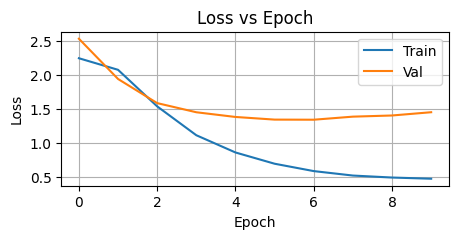

In [45]:
plt.figure(figsize=(5,2))
plt.plot(epoch_train_loss, label='Train')
plt.plot(epoch_val_loss, label='Val')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend();

# Evaluating the model

## Calculating the RMSE between the predicted labels and the true lables on different k-folds

In [55]:
# List to store the RMSE for each fold
rmses = []

# Loop over k-folds (in this case, 5 folds)
for k in range(1, 6):
    # Load training data for the k-th fold
    ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    train_ratings = pd.read_csv(f'../data/raw/u{k}.base', sep='\t', names=ratings_cols, encoding='latin-1')
    train_ratings["user_id"] = (train_ratings["user_id"] - 1).astype(int)
    train_ratings["movie_id"] = (train_ratings["movie_id"] - 1).astype(int)
    train_ratings = train_ratings[['user_id', 'movie_id', 'rating']]

    # Load testing data for the k-th fold
    test_ratings = pd.read_csv(f'../data/raw/u{k}.test', sep='\t', names=ratings_cols, encoding='latin-1')
    test_ratings["user_id"] = (test_ratings["user_id"] - 1).astype(int)
    test_ratings["movie_id"] = (test_ratings["movie_id"] - 1).astype(int)
    test_ratings = test_ratings[['user_id', 'movie_id', 'rating']]

    # Batch size for DataLoader
    batch_size = 8192

    # Creating Dataset and DataLoader for training and testing data
    train_dataset = MovieDataset(train_ratings)
    test_dataset = MovieDataset(test_ratings)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=0)

    # Initialize the model, optimizer, and loss function
    model = MatrixFactorization(len(users), len(movies), emb_dim).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Lists to store losses and RMSE for each epoch
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_rmse = []

    # Training loop for the specified number of epochs
    for i in range(num_epochs):
        train_loss = train_model(model, train_loader, optimizer, loss_fn, i)
        val_loss, rmse = validate_model(model, test_loader, loss_fn)
        epoch_train_loss.append(train_loss)
        epoch_val_loss.append(val_loss)
        epoch_rmse.append(rmse)

    # Calculate and store the final RMSE for the k-th fold
    _, fold_rmse = validate_model(model, test_loader, loss_fn)
    rmses.append(fold_rmse.item())
    print(f"RMSE for fold {k} is {fold_rmse.item():.1f}")

<ipython-input-30-d2997de8ea3a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item_ids = torch.tensor(item_ids).to(device, dtype=torch.long)
<ipython-input-43-4fcdb3cd5942>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item_ids = torch.tensor(item_ids).to(device, dtype=torch.long)


RMSE for fold 1 is 1.3


<ipython-input-30-d2997de8ea3a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item_ids = torch.tensor(item_ids).to(device, dtype=torch.long)
<ipython-input-43-4fcdb3cd5942>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item_ids = torch.tensor(item_ids).to(device, dtype=torch.long)


RMSE for fold 2 is 1.2


<ipython-input-30-d2997de8ea3a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item_ids = torch.tensor(item_ids).to(device, dtype=torch.long)
<ipython-input-43-4fcdb3cd5942>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item_ids = torch.tensor(item_ids).to(device, dtype=torch.long)


RMSE for fold 3 is 1.2


<ipython-input-30-d2997de8ea3a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item_ids = torch.tensor(item_ids).to(device, dtype=torch.long)
<ipython-input-43-4fcdb3cd5942>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item_ids = torch.tensor(item_ids).to(device, dtype=torch.long)


RMSE for fold 4 is 1.2


<ipython-input-30-d2997de8ea3a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item_ids = torch.tensor(item_ids).to(device, dtype=torch.long)
<ipython-input-43-4fcdb3cd5942>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item_ids = torch.tensor(item_ids).to(device, dtype=torch.long)


RMSE for fold 5 is 1.2


In [56]:
avg_rmse = sum(rmses)/len(rmses)
print(f"Average RMSE for Matrix factorization model is: {avg_rmse:.1f}")

Average RMSE for Matrix factorization model is: 1.2


## Recommend movies using the matrix factorization model

In [66]:
def recommend_movies(model, user_id, all_movies, train_data, movies_titles, num_recommendations=5):
    """
    Recommend movies for a given user ID based on a trained matrix factorization model.

    Args:
    model (MatrixFactorization): The trained recommendation model.
    user_id (int): The user ID for whom to make recommendations.
    all_movies (list): A list of all movie IDs.
    train_data (pd.DataFrame): The training dataset used for the model.
    movies_titles (dict): A dictionary mapping movie IDs to their titles.
    num_recommendations (int): The number of recommendations to return.

    Returns:
    list of tuples: Each tuple contains a movie ID and its title.
    """
    # Set the model to evaluation mode and disable gradient computation
    model.eval()
    with torch.no_grad():
        # Create tensors for the user ID and all movie IDs
        user_tensor = torch.tensor([user_id] * len(all_movies)).to(device, dtype=torch.long)
        movies_tensor = torch.tensor(all_movies).to(device, dtype=torch.long)

        # Predict ratings for all movies for the given user
        predicted_ratings = model(user_tensor, movies_tensor)
        predicted_ratings = predicted_ratings.cpu().numpy()

        # Identify movies already rated by the user
        rated_movies = set(train_data[train_data['user_id'] == user_id]['movie_id'])

        # Create a dictionary of predicted ratings, excluding already rated movies
        movie_ratings = {movie: rating for movie, rating in zip(all_movies, predicted_ratings) if movie not in rated_movies}

        # Sort the movies based on predicted ratings and select the top recommendations
        recommended_movies = sorted(movie_ratings, key=movie_ratings.get, reverse=True)[:num_recommendations]

        # Return the top recommended movies along with their titles
        return [(movie_id, movies_titles.get(movie_id, "Unknown Title")) for movie_id in recommended_movies]

# Example usage
user_id = 87  # Example user ID
all_movie_ids = list(range(len(movies)))  # List of all movie IDs
movies_titles = {int(movie_id): title for movie_id, title in zip(movies.movie_id, movies.title)}  # Dictionary mapping movie IDs to titles
recommended_movies = recommend_movies(model, user_id, all_movie_ids, train_ratings, movies_titles, num_recommendations=5)
print("Recommended Movies:", recommended_movies)


Recommended Movies: [(1509, 'Mad Dog Time (1996)'), (1389, 'Innocent Sleep, The (1995)'), (756, 'Across the Sea of Time (1995)'), (1588, 'Schizopolis (1996)'), (1366, 'Faust (1994)')]


In [86]:
def recommend_top_k(model, user_id, k, num_items):
    """
    Generates top-k recommendations for a given user.

    Args:
    model (nn.Module): Trained recommendation model.
    user_id (int): User ID for whom to generate recommendations.
    k (int): Number of top recommendations to return.
    num_items (int): Total number of items in the dataset.

    Returns:
    list: List of top-k recommended item IDs.
    """
    # Identify items that the user has already rated
    rated_items = set(train_ratings[train_ratings['user_id'] == user_id]['movie_id'])
    # List of items that the user has not rated
    unrated_items = [item for item in range(num_items) if item not in rated_items]

    # Predict ratings for unrated items
    predicted_ratings = []
    for item in unrated_items:
        predicted_rating = model(torch.tensor([user_id]).to(device), torch.tensor([item]).to(device))
        predicted_ratings.append((item, predicted_rating.item()))

    # Sort the predictions by rating and select the top k items
    top_k_items = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)[:k]

    return [item for item, rating in top_k_items]

def calculate_precision_at_k(model, k, num_items):
    """
    Calculates the precision at top-k for the recommendation model.

    Args:
    model (nn.Module): Trained recommendation model.
    k (int): The number of top items to consider for calculating precision.
    num_items (int): Total number of items in the dataset.

    Returns:
    float: The average precision at top-k across all users.
    """
    precisions = []
    # Iterate over all users
    for user_id in range(len(users)):
        # Get top-k recommendations for the user
        top_k_recommendations = recommend_top_k(model, user_id, k, num_items)
        # Get the actual items that the user rated positively
        actual_positive_items = test_ratings[(test_ratings['user_id'] == user_id) & (test_ratings['rating'] >= 4)]['movie_id'].tolist()
        # Calculate the number of true positives
        true_positives = len(set(top_k_recommendations).intersection(set(actual_positive_items)))
        # Calculate precision for the user
        precision = true_positives / k
        precisions.append(precision)

    # Calculate the mean precision across all users
    return np.mean(precisions)

# Calculate and print precision at top-k
precision_at_k = calculate_precision_at_k(model, k=5, num_items=len(movies))
print(f'Precision at Top 5: {precision_at_k}')


Precision at Top 5: 0.013255567338282079


# Out of curosity, I would like to try ALS model and see how it performs

Alternating Least Square (ALS) is also a matrix factorization algorithm and it runs itself in a parallel fashion. ALS is implemented in Apache Spark ML and built for a larges-scale collaborative filtering problems. ALS is doing a pretty good job at solving scalability and sparseness of the Ratings data, and it’s simple and scales well to very large datasets.

The code is inspired from [here](https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1)

In [67]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=c8dd4b8998162e197a4bbba0f534f5d6913ce6fdbe870bdb6adf3198d33b1984
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [68]:
import os
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [69]:
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

In [70]:
train_data = sc.parallelize(train_ratings[['user_id','movie_id', 'rating']].values.tolist())
test_data = sc.parallelize(test_ratings[['user_id','movie_id', 'rating']].values.tolist())


In [71]:
from pyspark.mllib.recommendation import ALS

def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model
# hyper-param config
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train_data, test_data, num_iterations, reg_params, ranks)

8 latent factors and regularization = 0.001: validation RMSE is 1.2804833792228287
8 latent factors and regularization = 0.01: validation RMSE is 1.069595618142095
8 latent factors and regularization = 0.05: validation RMSE is 0.9566634527668305
8 latent factors and regularization = 0.1: validation RMSE is 0.9252063973555407
8 latent factors and regularization = 0.2: validation RMSE is 0.9390112320883756
10 latent factors and regularization = 0.001: validation RMSE is 1.3392536769350052
10 latent factors and regularization = 0.01: validation RMSE is 1.1184715263446474
10 latent factors and regularization = 0.05: validation RMSE is 0.9669684090380057
10 latent factors and regularization = 0.1: validation RMSE is 0.9263410130792236
10 latent factors and regularization = 0.2: validation RMSE is 0.9396667936956263
12 latent factors and regularization = 0.001: validation RMSE is 1.469873458584308
12 latent factors and regularization = 0.01: validation RMSE is 1.1513023257205632
12 latent fa

In [72]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

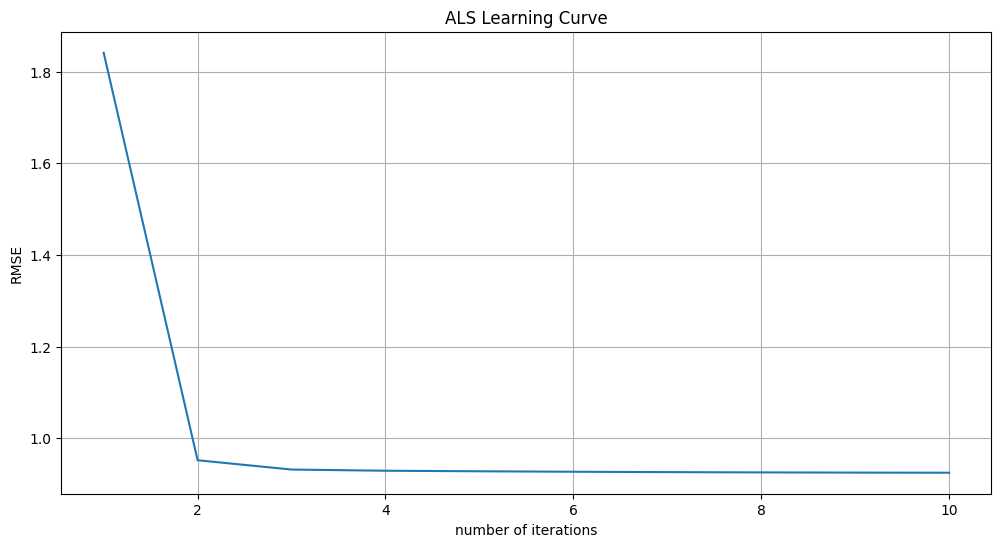

In [76]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train_data, test_data, 0.1, 20)

# References

- https://developers.google.com/machine-learning/recommendation
- https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1